In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [4]:
def get_data(n: int, d: int, sigma: float=0.01):
    x = torch.randn(n, d)
    y = 0.05 + 0.01 * x.sum(dim=1) + torch.randn(n,1)*sigma
    dataloader = torch.utils.data.DataLoader(
        dataset=torch.utils.data.TensorDataset(x,y),
        batch_size=5, shuffle=True
    )
    return dataloader

In [5]:
dataloader = get_data(n=100, d=10)

In [6]:
def l2_penalty(w):
    return (w**2).sum() / 2

In [7]:
class WeightDecayFromScrath:
    def __init__(self, num_inputs, sigma=0.01):
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def params(self): return [self.w, self.b]

    def __call__(self, x): return torch.matmul(x, self.w) + self.b

In [8]:
def get_criterion(lambd: float):
    def criterion(y_true, y_pred, w):
        return ((y_true-y_pred)**2 / 2).mean()+l2_penalty(w)*lambd
    return criterion

In [9]:
def train(lambd, criterion, optimizer, model, max_epochs=10, num_inputs = 200):
    train_dataloader = get_data(n=20, d=num_inputs)
    eval_dataloader = get_data(n=100, d=num_inputs)
    track_train_loss = []
    track_eval_loss = []
    for e in range(max_epochs):
        num_samples = 0
        epoch_loss = 0
        for batch in train_dataloader:
            if model.__class__.__name__.startswith("Concise"):
                loss = criterion(batch[-1], model(*batch[:-1]))
            else:
                loss = criterion(y_true=batch[-1], y_pred=model(*batch[:-1]), w=model.w)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            num_samples += batch[0].size(0)
            epoch_loss += loss.item()*batch[0].size(0)
        print(f"Epoch [{e}/{max_epochs}] loss: {epoch_loss/num_samples:.3f}")
        track_train_loss.append(epoch_loss/num_samples)

        num_samples = 0
        epoch_loss = 0
        for batch in eval_dataloader:
            num_samples += batch[0].size(0)
            if model.__class__.__name__.startswith("Concise"):
                loss = criterion(batch[-1], model(*batch[:-1]))
            else:
                loss = criterion(y_true=batch[-1], y_pred=model(*batch[:-1]), w=model.w)
            epoch_loss += loss.item()*batch[0].size(0)
        track_eval_loss.append(epoch_loss/num_samples)

    plt.plot(track_train_loss, label="train_loss")
    plt.plot(track_eval_loss, label="eval_loss")
    plt.yscale("log")
    plt.title(rf"$\lambda={lambd}$")
    plt.legend(); plt.show()
    try:
        print(f"L2 norm of w for lambda={lambd} is:", l2_penalty(model.w).item())
    except:
        print(f"L2 norm of w for lambda={lambd} is:", l2_penalty(model.net.weight).item())

Epoch [0/10] loss: 0.024
Epoch [1/10] loss: 0.020
Epoch [2/10] loss: 0.018
Epoch [3/10] loss: 0.017
Epoch [4/10] loss: 0.017
Epoch [5/10] loss: 0.016
Epoch [6/10] loss: 0.016
Epoch [7/10] loss: 0.016
Epoch [8/10] loss: 0.016
Epoch [9/10] loss: 0.016


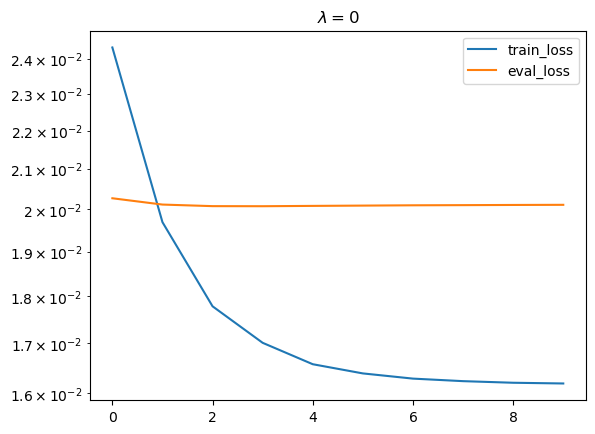

L2 norm of w for lambda=0 is: 0.009631644003093243
Epoch [0/10] loss: 0.047
Epoch [1/10] loss: 0.034
Epoch [2/10] loss: 0.028
Epoch [3/10] loss: 0.024
Epoch [4/10] loss: 0.021
Epoch [5/10] loss: 0.019
Epoch [6/10] loss: 0.017
Epoch [7/10] loss: 0.016
Epoch [8/10] loss: 0.015
Epoch [9/10] loss: 0.014


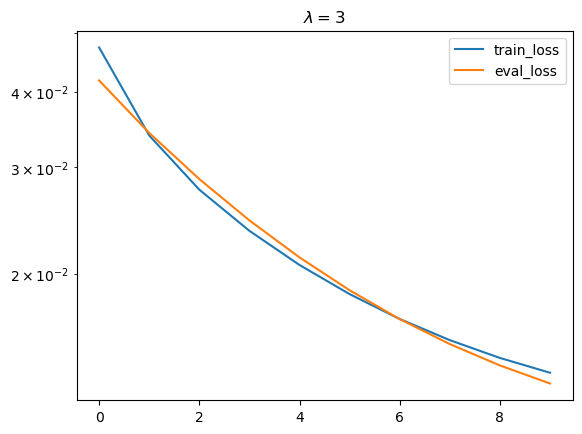

L2 norm of w for lambda=3 is: 0.0008286612574011087


In [10]:
num_inputs = 200 
for lambd in [0, 3]:
    model = WeightDecayFromScrath(num_inputs=num_inputs)
    train(lambd=lambd, model=model,
        optimizer = torch.optim.SGD(lr=0.01, params=model.params()),
        criterion = get_criterion(lambd),
    )

In [11]:
class ConciseLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

    def forward(self, x): return self.net(x)

Epoch [0/10] loss: 0.316
Epoch [1/10] loss: 0.045
Epoch [2/10] loss: 0.032
Epoch [3/10] loss: 0.030
Epoch [4/10] loss: 0.030
Epoch [5/10] loss: 0.030
Epoch [6/10] loss: 0.030
Epoch [7/10] loss: 0.030
Epoch [8/10] loss: 0.030
Epoch [9/10] loss: 0.030


/home/malick/miniconda3/envs/pt/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/malick/miniconda3/envs/pt/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


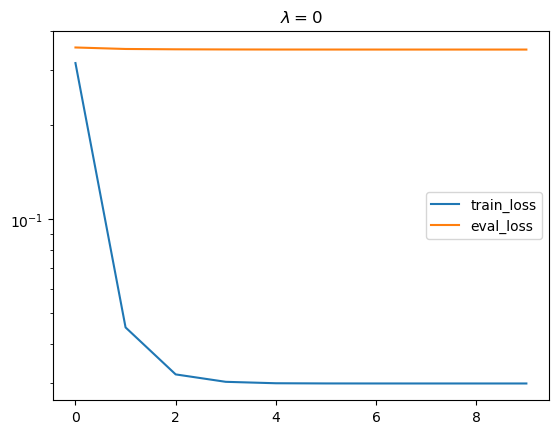

L2 norm of w for lambda=0 is: 0.14927323162555695
Epoch [0/10] loss: 0.297
Epoch [1/10] loss: 0.040
Epoch [2/10] loss: 0.022
Epoch [3/10] loss: 0.018
Epoch [4/10] loss: 0.017
Epoch [5/10] loss: 0.017
Epoch [6/10] loss: 0.017
Epoch [7/10] loss: 0.017
Epoch [8/10] loss: 0.017
Epoch [9/10] loss: 0.017


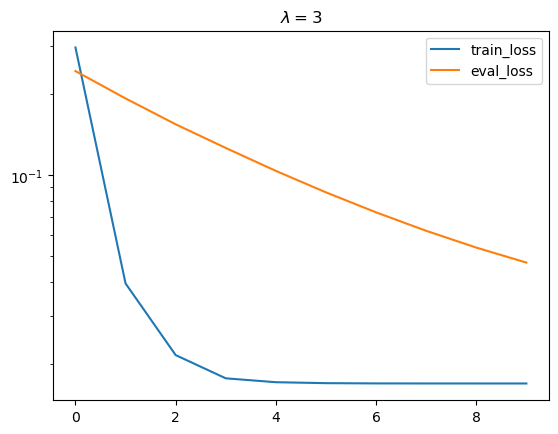

L2 norm of w for lambda=3 is: 0.011477855034172535


In [12]:
for lambd in [0, 3]:
    model = ConciseLinearModel()
    train(lambd=lambd, model=model,
        optimizer = torch.optim.SGD(lr=0.01, params=[
          {"params": model.net.weight, "weight_decay": lambd},
          {"params": model.net.bias}]),
        criterion = nn.MSELoss(),
    )